In [22]:
import pickle as pkl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyeasyfi.data.load_data import get_data_from_cb
from pyeasyfi.utils.utils import  get_top_n_cryptos
from pyeasyfi.utils.fin import compute_log_returns, compute_returns
from pyeasyfi.risks.asset.volatility import compute_historical_volatility, compute_GARCH_volatility
from pyeasyfi.risks.asset.value_at_risk import compute_historical_VaR, compute_var_covar_VaR, compute_montecarlo_VaR
from pyeasyfi.risks.portfolio.volatility import compute_portfolio_historical_variance
from pyeasyfi.utils.simulation_kernels.random_walk import RandomWalkSimulation


In [2]:
"""
crypto_list = get_top_n_cryptos(8)
data = get_data_from_cb(crypto_list, start_date='2021-06-01-00-00', end_date='2024-07-01-00-00', granularity=3600)
data.to_parquet("./historical_data.parquet")
data
"""

'\ncrypto_list = get_top_n_cryptos(8)\ndata = get_data_from_cb(crypto_list, start_date=\'2021-06-01-00-00\', end_date=\'2024-07-01-00-00\', granularity=3600)\ndata.to_parquet("./historical_data.parquet")\ndata\n'

In [3]:
data = pd.read_parquet("historical_data.parquet")


# We separate Cryptos

In [4]:
cryptos = set(data["crypto"])
data_dict = dict()

for crypto in cryptos : 
    data_dict[crypto] = data[data["crypto"] == crypto]

In [5]:
data_dict["BTC"]

,low,high,open,close,volume,crypto
time,,,,,,
2021-06-01 00:00:00,37140.92,37918.97,37276.23,37849.85,1382.050493,BTC
2021-06-01 01:00:00,37170.07,37831.06,37831.06,37200.52,632.492777,BTC
2021-06-01 02:00:00,36636.47,37300.00,37200.52,36860.57,647.014915,BTC
2021-06-01 03:00:00,36500.00,37139.33,36856.82,36714.69,555.584683,BTC
2021-06-01 04:00:00,36572.97,36956.48,36714.69,36753.45,331.339400,BTC
...,...,...,...,...,...,...
2024-06-30 20:00:00,61876.55,62300.00,61926.69,61888.93,277.524789,BTC
2024-06-30 21:00:00,61728.10,61921.79,61886.94,61828.03,123.826867,BTC
2024-06-30 22:00:00,61821.87,62850.00,61828.03,62793.77,679.187125,BTC


# Risk computation

## Compute volatility

In [6]:
# Historical Volatility
log_returns_dict = dict()
for key, value in data_dict.items() :
    log_returns_dict[key] = compute_log_returns(value["close"])
    volatility = compute_historical_volatility(log_returns_dict[key])
    print(f"Volatility for {key} : {volatility}")


Volatility for USDT : 0.007052450582130323
Volatility for XRP : 0.5746828326182557
Volatility for SOL : 1.102453537711951
Volatility for DOGE : 0.9669570100767776
Volatility for ETH : 0.7219536134327189
Volatility for BTC : 0.5849327443882928


In [7]:
# ARCH Volatility
arch_log_returns_dict = dict()
for key, value in data_dict.items() :
    arch_log_returns_dict[key] = compute_log_returns(value["close"])
    volatility, model = compute_GARCH_volatility(arch_log_returns_dict[key]) # Auto manage rescaling
    print(f"Volatility for {key} : {volatility}")

Inequality constraints incompatible    (Exit mode 4)
            Current function value: -7507.498287218492
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Volatility for USDT : 0.007345798532811125
Optimization terminated successfully    (Exit mode 0)
            Current function value: -754.2184966492086
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 6
Volatility for XRP : 0.43928632027831244
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1670.8711132354301
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Volatility for SOL : 0.970427842703012
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1835.2107355194007
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2
Volatility for DOGE : 0.7395971805395661
O

/home/jean-marc/anaconda3/envs/streamlit/lib/python3.10/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.362e-07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/jean-marc/anaconda3/envs/streamlit/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/jean-marc/anaconda3/envs/streamlit/lib/python3.10/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0

## Test Random Walk MonteCarlo simulation

In [8]:
list(data_dict["DOGE"]['close'])[-1]

0.12473

#### On Log returns

In [9]:
returns = compute_log_returns(data_dict["DOGE"]["close"])
simulator  = RandomWalkSimulation(returns, list(data_dict["DOGE"]['close'])[-1])
sim_results = simulator.run(150)
sim_results

,sim_1,sim_2,sim_3,sim_4,sim_5,sim_6,sim_7,sim_8,sim_9,sim_10,...,sim_141,sim_142,sim_143,sim_144,sim_145,sim_146,sim_147,sim_148,sim_149,sim_150
0,0.114978,0.114321,0.117484,0.123820,0.139931,0.133035,0.130479,0.125111,0.116723,0.131462,...,0.125399,0.123309,0.121563,0.125856,0.121116,0.123756,0.138407,0.119996,0.119037,0.122214
1,0.115247,0.102946,0.131928,0.129168,0.137662,0.143661,0.131908,0.128931,0.123761,0.133913,...,0.122861,0.128077,0.117762,0.114591,0.114864,0.133753,0.145934,0.124974,0.118895,0.129170
2,0.118041,0.101940,0.130495,0.140666,0.131316,0.150071,0.128086,0.124087,0.117751,0.138618,...,0.140883,0.126059,0.110700,0.105748,0.119056,0.134860,0.153075,0.124891,0.121320,0.125249
3,0.130811,0.100901,0.120511,0.144765,0.136765,0.150843,0.133645,0.122538,0.117176,0.145581,...,0.133117,0.120283,0.113474,0.103881,0.117313,0.135234,0.166546,0.133228,0.129879,0.124522
4,0.129337,0.097512,0.123060,0.148650,0.144730,0.161875,0.132594,0.125074,0.111054,0.139706,...,0.133197,0.104563,0.112824,0.099046,0.111420,0.140983,0.165178,0.138977,0.123940,0.121783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.010981,0.011494,0.027714,0.022763,0.053720,0.072665,0.035849,0.065666,0.101536,0.082511,...,0.131955,0.073813,0.039900,0.005801,0.101886,0.032256,0.046938,0.064213,0.194724,0.019355
361,0.011358,0.011105,0.025196,0.021816,0.053182,0.070632,0.032917,0.063254,0.099172,0.076580,...,0.128501,0.072595,0.040348,0.006005,0.100228,0.033518,0.047300,0.061251,0.178756,0.018881
362,0.011068,0.012550,0.027647,0.023292,0.051804,0.072511,0.032816,0.064061,0.102302,0.076949,...,0.136628,0.070460,0.039999,0.006975,0.096346,0.032146,0.047471,0.058506,0.190145,0.018997
363,0.010892,0.012954,0.027039,0.022872,0.049070,0.068349,0.032459,0.066966,0.102957,0.074986,...,0.129363,0.071123,0.034957,0.007072,0.101402,0.031339,0.047031,0.057955,0.179835,0.019618


<Axes: >

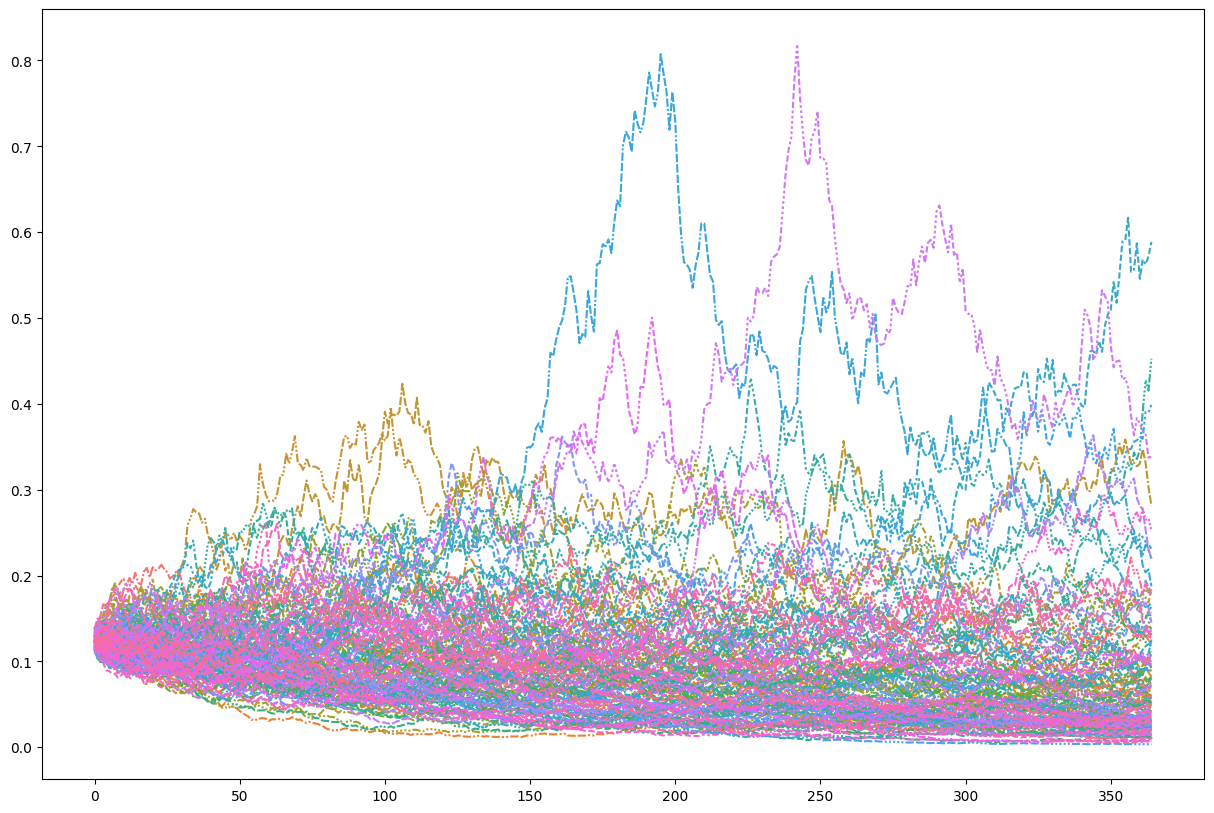

In [10]:
plt.figure(figsize=(15,10))
sns.lineplot(sim_results, legend=False)

#### On returns

In [11]:
"""returns = compute_returns(data_dict["DOGE"]["close"])
simulator  = RandomWalkSimulation(returns, list(data_dict["DOGE"]['close'])[-1]) #shouldn't use on normal returns
sim_results = simulator.run(150)
sim_results"""

'returns = compute_returns(data_dict["DOGE"]["close"])\nsimulator  = RandomWalkSimulation(returns, list(data_dict["DOGE"][\'close\'])[-1]) #shouldn\'t use on normal returns\nsim_results = simulator.run(150)\nsim_results'

In [12]:
"""plt.figure(figsize=(15,10))
sns.lineplot(sim_results, legend=False)"""

'plt.figure(figsize=(15,10))\nsns.lineplot(sim_results, legend=False)'

## Compute Value At Risk

In [13]:
# Historical VaR
returns_dict = dict()
for key, value in data_dict.items() :
    log_returns_dict[key] = compute_returns(value["close"])
    var = compute_historical_VaR(log_returns_dict[key])
    print(f"Value at risk for {key} : {var}")

Value at risk for USDT : -0.042004725815977806
Value at risk for XRP : -4.524782378479985
Value at risk for SOL : -8.28361922220767
Value at risk for DOGE : -7.278290647656764
Value at risk for ETH : -6.161158608918638
Value at risk for BTC : -4.720670457190191


In [14]:
# Variance covariance VAR
returns_dict = dict()
for key, value in data_dict.items() :
    log_returns_dict[key] = compute_returns(value["close"])
    var = compute_var_covar_VaR(log_returns_dict[key])
    print(f"Value at risk for {key} : {var}")

Value at risk for USDT : -0.060807520285878394
Value at risk for XRP : -5.0344351683428075
Value at risk for SOL : -9.132256875995385
Value at risk for DOGE : -8.359920373840474
Value at risk for ETH : -6.100544229610936
Value at risk for BTC : -4.928948123653993


In [15]:
# Variance covariance VAR --> this is 95 annual loss en pct
returns_dict = dict()
for key, value in data_dict.items() :
    log_returns_dict[key] = compute_log_returns(value["close"])
    var = compute_montecarlo_VaR(log_returns_dict[key], start_price=value['close'][-1], n_simulations=100000, horizon=365)
    print(f"Value at risk for {key} : {var}")

Value at risk for USDT : -1.1998809546841513
Value at risk for XRP : -81.03974657397711
Value at risk for SOL : -86.15786782412049
Value at risk for DOGE : -91.13098190641936
Value at risk for ETH : -74.27853065558361
Value at risk for BTC : -61.584957369752956


# Compute Portfolio Risk

In [16]:
assets_df = pd.DataFrame()
for key, value in data_dict.items():
    assets_df[f"{key}"] = value["close"]
assets_df = assets_df.dropna()
#assets_df.index = assets_df["time"]
#assets_df = assets_df[list(data_dict.keys())]
#assets_df

In [17]:
log_ret = compute_log_returns(assets_df, return_pandas=True)
log_ret

,USDT,XRP,SOL,DOGE,ETH,BTC
0,0.000120,-0.129191,0.025414,-0.027782,-0.033992,-0.036938
1,-0.000250,-0.005022,0.028431,0.048992,-0.003622,-0.000952
2,0.000210,0.044452,-0.001457,-0.033638,-0.004420,-0.001784
3,-0.000330,-0.013197,-0.022862,0.004303,-0.006259,-0.003463
4,0.000020,0.054089,-0.047746,-0.017178,-0.007172,-0.009371
...,...,...,...,...,...,...
349,-0.000801,0.011228,0.089228,0.033980,0.022384,0.013048
350,-0.000501,-0.008250,-0.067307,-0.032677,-0.021106,-0.021358
351,0.000321,0.002334,0.001787,-0.009242,-0.000107,0.009444
352,-0.000040,0.007179,0.044495,0.020817,0.017371,0.028857


In [18]:
ret_df = compute_returns(assets_df, return_pandas=True)
ret_df

,USDT,XRP,SOL,DOGE,ETH,BTC
time,,,,,,
2023-07-14,0.011995,-12.119359,2.573953,-2.739920,-3.342057,-3.626449
2023-07-15,-0.024987,-0.500974,2.883895,5.021165,-0.361543,-0.095185
2023-07-16,0.020994,4.545455,-0.145613,-3.307853,-0.441017,-0.178241
2023-07-17,-0.032984,-1.311037,-2.260299,0.431220,-0.623902,-0.345680
2023-07-18,0.002000,5.557815,-4.662439,-1.703163,-0.714667,-0.932718
...,...,...,...,...,...,...
2024-06-27,-0.080052,1.129101,9.332943,3.456428,2.263668,1.313307
2024-06-28,-0.050073,-0.821572,-6.509232,-3.214877,-2.088473,-2.113173
2024-06-29,0.032063,0.233645,0.178891,-0.919971,-0.010671,0.948911


### Same Weight

In [19]:
nb_cryptos = len(data_dict.keys())
weights = [1/nb_cryptos] * nb_cryptos

In [20]:
compute_portfolio_historical_variance(log_ret, weights)

[[-1.66666625e-01  1.26850286e-07  7.34740256e-07  4.35957617e-07
   3.76817583e-07  5.41852956e-07]
 [ 1.26850286e-07 -1.66364839e-01  1.14888139e-04  1.25991731e-04
   8.55865226e-05  7.81387814e-05]
 [ 7.34740256e-07  1.14888139e-04 -1.65939277e-01  1.76662352e-04
   1.26617881e-04  1.26469755e-04]
 [ 4.35957617e-07  1.25991731e-04  1.76662352e-04 -1.66017104e-01
   1.29432203e-04  1.29144214e-04]
 [ 3.76817583e-07  8.55865226e-05  1.26617881e-04  1.29432203e-04
  -1.66408396e-01  9.18813009e-05]
 [ 5.41852956e-07  7.81387814e-05  1.26469755e-04  1.29144214e-04
   9.18813009e-05 -1.66459792e-01]]


-0.9954819747015082

In [21]:
compute_portfolio_historical_variance(ret_df, weights)

[[-1.66248799e-01  1.28961713e-03  7.47975477e-03  4.54394163e-03
   3.80817058e-03  5.47879204e-03]
 [ 1.28961713e-03  2.82748187e+00  1.13481049e+00  1.23447706e+00
   8.45435930e-01  7.69891597e-01]
 [ 7.47975477e-03  1.13481049e+00  7.37363459e+00  1.77775841e+00
   1.27612691e+00  1.28083940e+00]
 [ 4.54394163e-03  1.23447706e+00  1.77775841e+00  6.51871180e+00
   1.30451403e+00  1.30899907e+00]
 [ 3.80817058e-03  8.45435930e-01  1.27612691e+00  1.30451403e+00
   2.49275981e+00  9.28809844e-01]
 [ 5.47879204e-03  7.69891597e-01  1.28083940e+00  1.30899907e+00
   9.28809844e-01  1.92666787e+00]]


44.74153317248413